In [1]:
!pip install openjij

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2


For n = 8 cities:
Brute Force Route: (0, 3, 7, 4, 5, 6, 1, 2)
Brute Force Total Distance: 181
Brute Force Time: 0.270586 seconds
Quantum Annealing Route: [0, 1, 3, 7, 4, 2, 5, 6]
Quantum Annealing Minimum Distance: 156
Quantum Annealing Time: 2.448965 seconds
Serial Route: [0, 1, 2, 4, 5, 6, 7, 3]
Serial Total Distance: 248
Serial Time: 0.000199 seconds

For n = 9 cities:
Brute Force Route: (0, 3, 4, 6, 7, 8, 2, 5, 1)
Brute Force Total Distance: 179
Brute Force Time: 1.211793 seconds
Quantum Annealing Route: [0, 3, 4, 5, 1, 2, 6, 7, 8]
Quantum Annealing Minimum Distance: 223
Quantum Annealing Time: 3.423241 seconds
Serial Route: [0, 1, 2, 5, 4, 6, 7, 8, 3]
Serial Total Distance: 260
Serial Time: 0.000182 seconds

For n = 10 cities:
Brute Force Route: (0, 9, 6, 1, 8, 3, 7, 5, 4, 2)
Brute Force Total Distance: 145
Brute Force Time: 14.667758 seconds
Quantum Annealing Route: [0, 1, 4, 2, 3, 7, 5, 9, 6, 8]
Quantum Annealing Minimum Distance: 215
Quantum Annealing Time: 4.696800 seconds
Se

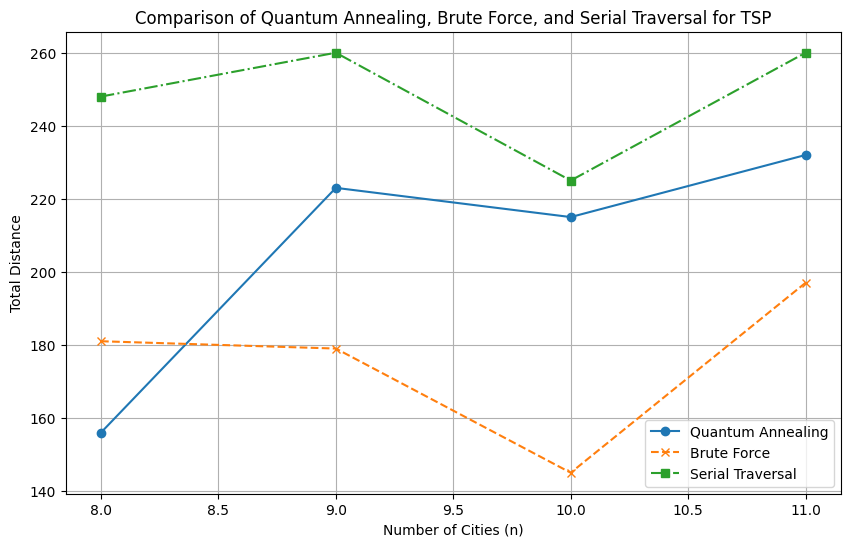

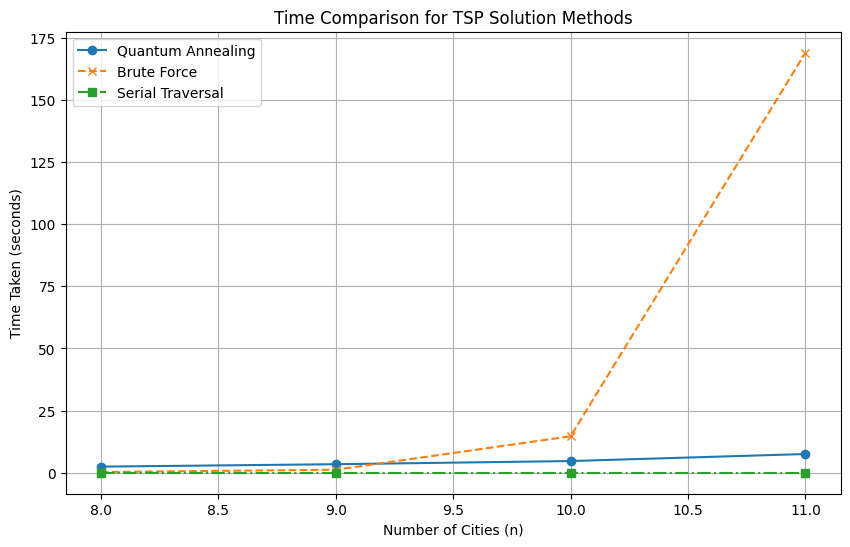

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import openjij as oj
from itertools import permutations

# Generate random distance matrix
def generate_distance_matrix(n, seed=99):
    if seed is not None:
        np.random.seed(seed)

    dist = np.random.randint(1, 100, size=(n, n))
    np.fill_diagonal(dist, 0)  # same city has 0 zero distance to itself
    return dist

# Brute force TSP solver
def solve_tsp_bruteforce(dist):
    n = dist.shape[0]
    min_distance = float('inf')
    best_tour = None
    for perm in permutations(range(n)):
        total_distance = sum(dist[perm[i], perm[i + 1]] for i in range(n - 1))
        total_distance += dist[perm[-1], perm[0]]  # Returning to the start
        if total_distance < min_distance:
            min_distance = total_distance
            best_tour = perm
    return best_tour, min_distance

# Solve TSP using Quantum Annealing
def solve_tsp_qaoa(dist):
    n = dist.shape[0]
    Q = create_qubo_matrix(dist)

    # Quantum Annealing solver
    sampler = oj.SASampler()
    num_reads = 1000  # number of samples taken in each run
    max_resamples = 5
    best_tour = None
    best_distance = float('inf')
    best_time = float('inf')
    total_qaoa_time = 0  # To accumulate total time taken across attempts
    attempts = 0

    while attempts < max_resamples:
        start_time = time.time()
        response = sampler.sample_qubo(Q, num_reads=num_reads)
        end_time = time.time()

        # Accumulate time for this attempt
        attempt_time = end_time - start_time
        total_qaoa_time += attempt_time

        # Process all samples and select the best one (min cost)
        for sample in response.data():
            solution = sample[0]
            total_distance = 0
            tour = []
            visited = [False] * n
            current_city = 0  # Start at city 0
            tour.append(current_city)
            visited[current_city] = True

            # Extract tour by following city-to-city transitions
            while len(tour) < n:
                found_next_city = False
                for j in range(n):
                    if solution[current_city * n + j] == 1 and not visited[j]:
                        tour.append(j)
                        total_distance += dist[current_city][j]
                        visited[j] = True
                        current_city = j
                        found_next_city = True
                        break

                if not found_next_city:
                    break

            # Update best solution if needed
            if len(tour) == n and total_distance < best_distance:
                best_tour = tour
                best_distance = total_distance
                best_time = attempt_time  # Record the time of the best solution

        if best_tour:
            attempts += 1
        else:
            attempts += 1
            print(f"Attempt {attempts} failed. Resampling...")

    # Return best solution, minimum cost, and its time
    return best_tour, best_distance, best_time

# Create the QUBO matrix
def create_qubo_matrix(dist):
    n = dist.shape[0]
    Q = np.zeros((n*n, n*n))
    for i in range(n):
        for j in range(i+1, n):
            Q[i*n + j, j*n + i] = dist[i, j]
            Q[j*n + i, i*n + j] = dist[i, j]
    return Q

# TSP (simple traversal)
def solve_tsp_serial(dist):
    n = dist.shape[0]
    visited = [False] * n
    total_distance = 0
    current_city = 0
    visited[current_city] = True
    tour = [current_city]

    while len(tour) < n:
        next_city = np.argmin([dist[current_city, i] if not visited[i] else np.inf for i in range(n)])
        tour.append(next_city)
        total_distance += dist[current_city, next_city]
        visited[next_city] = True
        current_city = next_city

    total_distance += dist[current_city, tour[0]]  # Return to the start city
    return tour, total_distance

# Main execution for comparison
def compare_methods():
    n_values = range(8, 12) #define n range
    qaoa_distances = []
    brute_force_distances = []
    serial_distances = []
    qaoa_times = []
    brute_force_times = []
    serial_times = []
    qaoa_routes = []
    brute_force_routes = []
    serial_routes = []

    for n in n_values:
        dist_matrix = generate_distance_matrix(n)

        # Brute force solution
        start_time = time.time()
        brute_force_route, brute_force_distance = solve_tsp_bruteforce(dist_matrix)
        end_time = time.time()
        brute_force_times.append(end_time - start_time)
        brute_force_distances.append(brute_force_distance)
        brute_force_routes.append(brute_force_route)

        # Quantum Annealing
        qaoa_route, qaoa_distance, qaoa_time = solve_tsp_qaoa(dist_matrix)
        qaoa_distances.append(qaoa_distance)
        qaoa_times.append(qaoa_time)
        qaoa_routes.append(qaoa_route)

        # Serial traversal
        start_time = time.time()
        serial_route, serial_distance = solve_tsp_serial(dist_matrix)
        end_time = time.time()
        serial_times.append(end_time - start_time)
        serial_distances.append(serial_distance)
        serial_routes.append(serial_route)

    # results
    for i, n in enumerate(n_values):
        print(f"\nFor n = {n} cities:")
        print(f"Brute Force Route: {brute_force_routes[i]}")
        print(f"Brute Force Total Distance: {brute_force_distances[i]}")
        print(f"Brute Force Time: {brute_force_times[i]:.6f} seconds")
        print(f"Quantum Annealing Route: {qaoa_routes[i]}")
        print(f"Quantum Annealing Minimum Distance: {qaoa_distances[i]}")
        print(f"Quantum Annealing Time: {qaoa_times[i]:.6f} seconds")
        print(f"Serial Route: {serial_routes[i]}")
        print(f"Serial Total Distance: {serial_distances[i]}")
        print(f"Serial Time: {serial_times[i]:.6f} seconds")

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, qaoa_distances, label="Quantum Annealing", marker='o')
    plt.plot(n_values, brute_force_distances, label="Brute Force", marker='x', linestyle='--')
    plt.plot(n_values, serial_distances, label="Serial Traversal", marker='s', linestyle='-.')

    plt.xlabel("Number of Cities (n)")
    plt.ylabel("Total Distance")
    plt.title("Comparison of Quantum Annealing, Brute Force, and Serial Traversal for TSP")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting time taken
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, qaoa_times, label="Quantum Annealing", marker='o')
    plt.plot(n_values, brute_force_times, label="Brute Force", marker='x', linestyle='--')
    plt.plot(n_values, serial_times, label="Serial Traversal", marker='s', linestyle='-.')

    plt.xlabel("Number of Cities (n)")
    plt.ylabel("Time Taken (seconds)")
    plt.title("Time Comparison for TSP Solution Methods")
    plt.legend()
    plt.grid(True)
    plt.show()

# comparison
compare_methods()
